### 1.1 Data Acquisition and Alignment

#### Import libraries

In [1]:
import importlib 
import os
import acquisition_alignment.dl_functions
import acquisition_alignment.connect_openeo
import acquisition_alignment.plt_functions

from acquisition_alignment.dl_functions import download_and_process_osm_data, download_sentinel2_images_openeo
from acquisition_alignment.connect_openeo import connect_to_openeo
from acquisition_alignment.plt_functions import plot_city_buildings, rgb_image, single_band_image, overlay_image, irb_image, stretch_contrast, get_epsg_from_tif, reproject_gdf

from preparation.preparation import cloud_classifier, create_building_mask, extract_patches
from preparation.gen_dataset import save_patches_and_masks, pair_files, split_and_save

from modeling_tuning.build_dataset import BuildingDataset
from modeling_tuning.build_classifier import BuildingClassifier

importlib.reload(acquisition_alignment.plt_functions)
importlib.reload(acquisition_alignment.dl_functions)
#importlib.reload(acquisition_alignment.connect_openeo)

<module 'acquisition_alignment.dl_functions' from 'c:\\Users\\PC\\Desktop\\TU\\AMLS\\acquisition_alignment\\dl_functions.py'>

#### Loop through 10 'big' cities and download OSM Data

In [2]:
pyrosm_path = f"acquisition_alignment/pyrosm_cities/"
# Ensure the directory exists
os.makedirs(pyrosm_path, exist_ok=True)

# List of 10 'big' cities
city_names = ["Tokyo", "New York City", "Bangkok", "Stockholm", "Sydney", "SanktPetersburg", "Moscow", "Muenchen", "Hannover", "Dublin"]
# city_names = ["Berlin"]

cities_data = {}

# Loop through each city
for city in city_names:
    # Download and process OSM data
    buildings_gdf, bbox = download_and_process_osm_data(city, pyrosm_path) # buildings_gdf crs=4326, [north, south, west, east]
    cities_data[city] = [buildings_gdf, bbox]
    print(f"Download, get building and boundaries of {city} done.\n")
    break


Tokyo data was downloaded to: c:\Users\PC\Desktop\TU\AMLS\acquisition_alignment\pyrosm_cities\Tokyo.osm.pbf
OSM data get_buildings done.
OSM for Tokyo converted into GeoDataFrame, with crs=EPSG:4326 done.
OSM data get_boundaries done.
Download, get building and boundaries of Tokyo done.



#### Connect to openeo.dataspace.copernicus

In [17]:
# Connect to OpenEO
connection = connect_to_openeo()

Connecting to OpenEO...
Authenticated using refresh token.
Connected to OpenEO.



#### Download Sentinel 2 L2a Data

In [ ]:
openeo_path = "acquisition_alignment/openeo_cities/Tokyo"
# Ensure the directory exists
os.makedirs(openeo_path, exist_ok=True)

# Download Sentinel-2 L2a images
dates_interval = ["2021-06-01T12:00:00Z", "2021-06-16T12:01:00Z"]
cloud_cover_percentage = 6

# Loop through each city and get Sentinel 2 L2a files
for city in city_names:
    # Call the download function
    download_sentinel2_images_openeo(connection, bbox, dates_interval, cloud_cover_percentage, city)
    break

_, bbox = cities_data["Tokyo"]
print(bbox)
download_sentinel2_images_openeo(connection, bbox, dates_interval, cloud_cover_percentage, "Tokyo", openeo_path)

#### Buildings Plot and Images

In [3]:
sentinel2_path = "acquisition_alignment/openeo_cities/Tokyo/openEO_2021-06-11Z.tif"  # Path to the Sentinel-2 L2a image of a city
band_index = 1  # For single band. Band index to read (1 for B04, 2 for B03, 3 for B02, 4 for B08) (cmap=gray anyway)

# Loop through each city in the dictionary and save image of the buildings of the city
for city, data in cities_data.items():
    buildings_gdf, bbox = data

    # Make directory for the images (for city). Ensure the directory exists
    images_save_dir = f"acquisition_alignment/images/{city}/"
    os.makedirs(images_save_dir, exist_ok=True)

    print("1 (a) Buildings from OpenStreetMaps.")
    # plot_city_buildings(city, buildings_gdf, images_save_dir)

    print("1 (b) RGB Bands from Sentinel 2.")
    # rgb_image(sentinel2_path, images_save_dir)

    print("2 (a) Single Band.")
    # single_band_image(sentinel2_path, images_save_dir, band_index)

    print("2 (b) Overlap Buildings from OSM onto Sentinel-2 image.")
    # overlay_image(buildings_gdf, sentinel2_path, images_save_dir, band_index)

    print("2 (c) IRB")
    # irb_image(sentinel2_path, images_save_dir)
    
    break

1 (a) Buildings from OpenStreetMaps.
1 (b) RGB Bands from Sentinel 2.
2 (a) Single Band.
2 (b) Overlap Buildings from OSM onto Sentinel-2 image.
2 (c) IRB


### 1.2 Data Preparation

In [ ]:
import rasterio
import numpy as np

# Load the Sentinel-2 image
image_path = "acquisition_alignment/openeo_cities/Tokyo/openEO_2021-06-11Z.tif"
satellite_crs = get_epsg_from_tif(image_path)
buildings_gdf = reproject_gdf(buildings_gdf, satellite_crs)

# Patch extraction
patch_size = 128  # Example patch size

with rasterio.open(image_path) as src:
    transform = src.transform
    width = src.width
    height = src.height

    red = src.read(1) # * 0.0001 # B04
    green = src.read(2) # * 0.0001  # B03
    blue = src.read(3) # * 0.0001  # B02

    # Stretch the contrast of each band
    red_stretched = stretch_contrast(red)
    green_stretched = stretch_contrast(green)
    blue_stretched = stretch_contrast(blue)

    sentinel_image = np.dstack((red_stretched, green_stretched, blue_stretched)) # [H, W, C]

In [6]:
buildings_mask = create_building_mask(buildings_gdf, transform, width, height)

In [15]:
import torch 

patches_image, patches_mask = extract_patches(sentinel_image, buildings_mask, patch_size)

# Convert to PyTorch tensors
tensor_image = torch.tensor(patches_image, dtype=torch.float32)
tensor_mask = torch.tensor(patches_mask, dtype=torch.long)  # Masks are typically long integers in PyTorch

# Ensure the dimensions are [N, H, W, C] for images and [N, H, W] for masks
tensor_image = tensor_image.permute(0, 1, 2, 3)
tensor_mask = tensor_mask.permute(0, 1, 2)

# Output
print("Image tensor shape:", tensor_image.shape)
print("Mask tensor shape:", tensor_mask.shape)

Image tensor shape: torch.Size([351, 128, 128, 3])
Mask tensor shape: torch.Size([351, 128, 128])


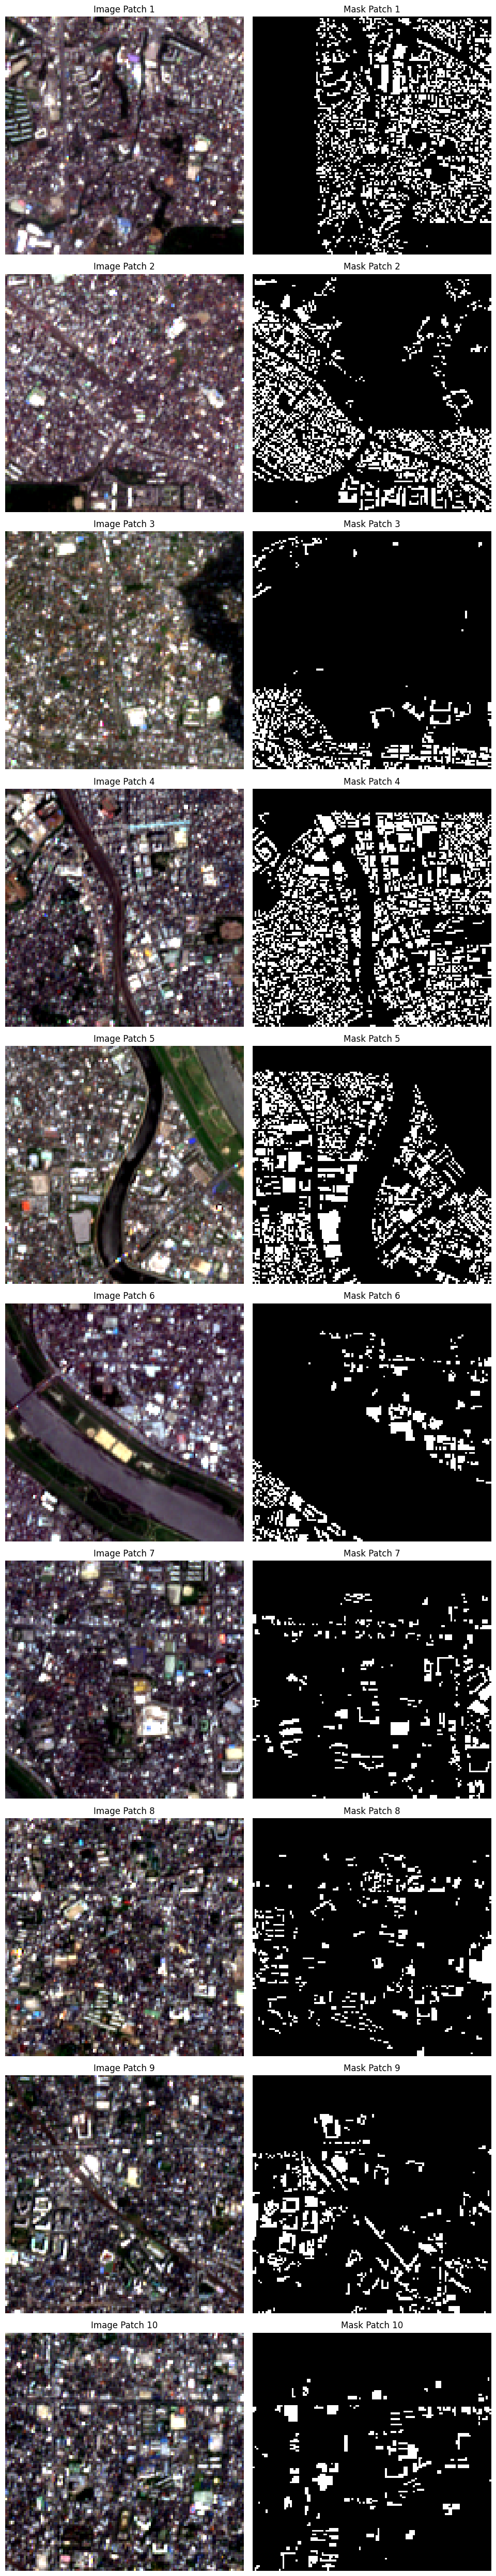

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_patches(tensor_image, tensor_mask, num_patches=10):
    fig, axs = plt.subplots(num_patches, 2, figsize=(10, num_patches * 5))
    for i in range(num_patches):
        # Convert the tensor image to numpy and move the channels to the last dimension
        img = tensor_image[i]
        
        # Stretch contrast for each channel (R, G, B, NIR)
        img_stretched = np.zeros_like(img)
        for c in range(img.shape[2]):
            img_stretched[:, :, c] = stretch_contrast(img[:, :, c])
        
        # Normalize the stretched image for visualization
        img_stretched = (img_stretched - np.min(img_stretched)) / (np.max(img_stretched) - np.min(img_stretched))
        
        # Display the image
        axs[i, 0].imshow(img_stretched[:, :, :3])  # Display only RGB channels

        axs[i, 0].set_title(f'Image Patch {i+1}')
        axs[i, 0].axis('off')
        
        # Display the mask
        axs[i, 1].imshow(tensor_mask[i].numpy(), cmap='gray')
        axs[i, 1].set_title(f'Mask Patch {i+1}')
        axs[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize the first 10 patches
visualize_patches(tensor_image, tensor_mask, num_patches=10)


In [17]:
# Example usage
output_directory = 'preparation/data/'
save_patches_and_masks(tensor_image, tensor_mask, output_directory, city, prefix='patch')


Saved 351 image patches and masks to preparation/data/


In [18]:
image_dir = 'preparation/data/all_images'
mask_dir = 'preparation/data/all_masks'
paired_files = pair_files(image_dir, mask_dir)
print(len(paired_files))

351


In [117]:
output_directory = 'preparation/data'
split_and_save(paired_files, output_directory)

Saved 224 train, 56 validation, and 71 test file pairs.


### 1.3 Modeling and Tuning

#### Building Dataset

In [53]:
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

train_dataset = BuildingDataset("preparation/data/train/images", "preparation/data/train/masks", transform)
val_dataset = BuildingDataset("preparation/data/val/images", "preparation/data/val/masks", transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


cuda


#### Init <b>Baseline</b> Model

In [51]:
model = BuildingClassifier(in_channels=3).to(device)

#### Train

In [45]:
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss with logits
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        
        outputs = model(images)

        outputs = outputs.squeeze(1)  # Remove channel dimension
        masks = masks.squeeze(1)
        
        loss = criterion(outputs, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)

            outputs = outputs.squeeze(1)
            masks = masks.squeeze(1)

            loss = criterion(outputs, masks)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/2, Train Loss: 0.4721, Val Loss: 0.4427
Epoch 2/2, Train Loss: 0.4288, Val Loss: 0.4351


#### Evaluate

In [27]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        
        outputs = model(images)
        preds = torch.sigmoid(outputs).cpu().numpy()
        preds = (preds > 0.5).astype(np.uint8)
        
        all_preds.extend(preds.flatten())
        all_labels.extend(masks.cpu().numpy().flatten())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.8391, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000


#### Load Test Dataset

In [28]:
# Assuming similar structure to the training and validation datasets
test_dataset = BuildingDataset("preparation/data/test/images", "preparation/data/test/masks", transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#### Test the Model

In [29]:
# Set the model to evaluation mode
model.eval()

# Lists to store all predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        
        # Get model outputs
        outputs = model(images)  # outputs: [N, H, W]
        preds = torch.sigmoid(outputs).cpu().numpy()
        preds = (preds > 0.5).astype(np.uint8)  # Threshold to get binary predictions
        
        # Flatten the predictions and labels to compute metrics
        all_preds.extend(preds.flatten())
        all_labels.extend(masks.cpu().numpy().flatten())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.8375
Test Precision: 0.0000
Test Recall: 0.0000
Test F1-Score: 0.0000


#### Visualize GT vs. Test Predictions without Hyper-Parameter Tuning

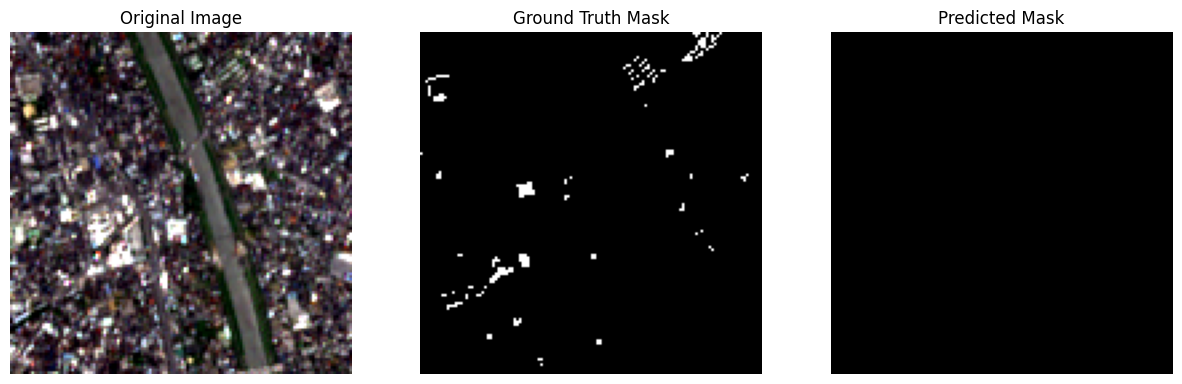

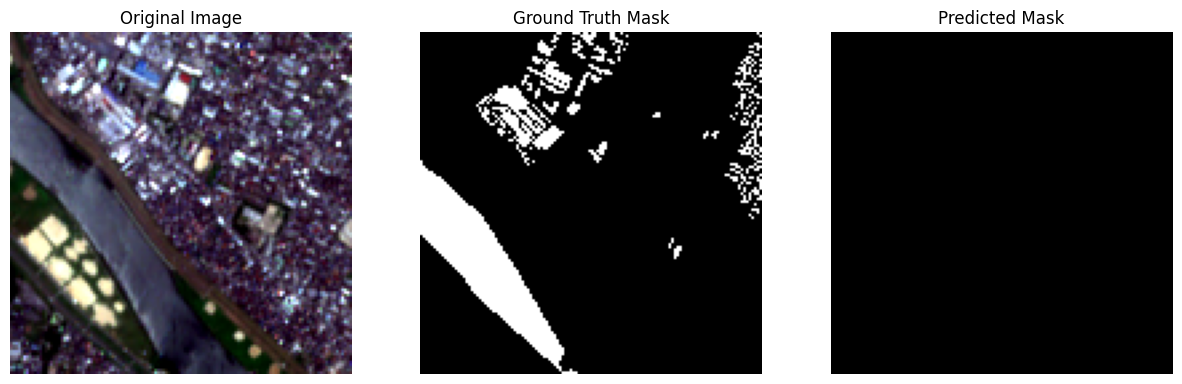

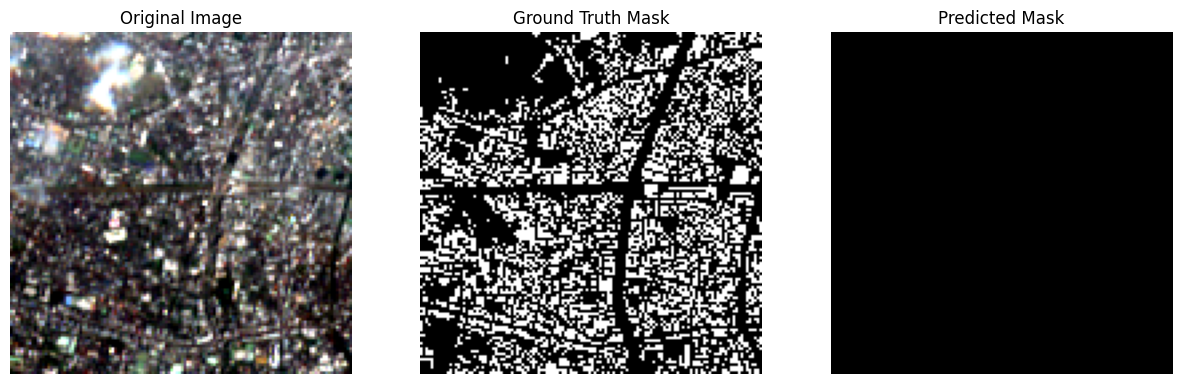

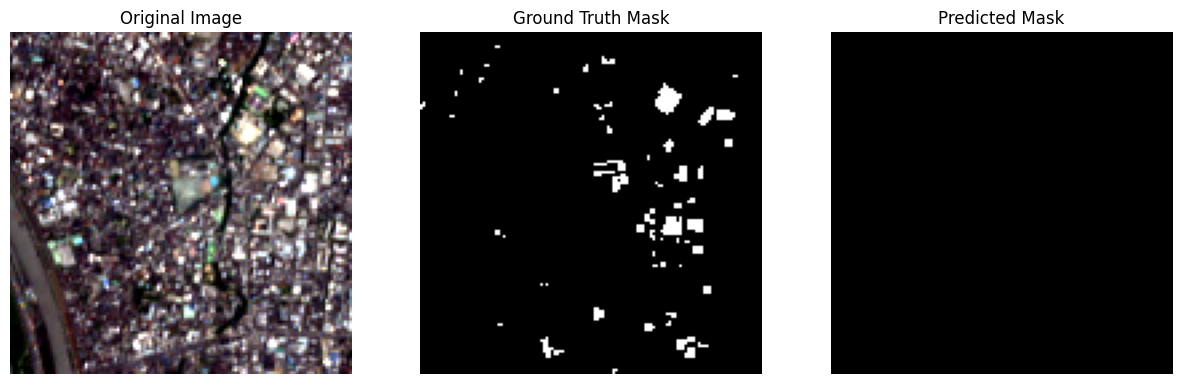

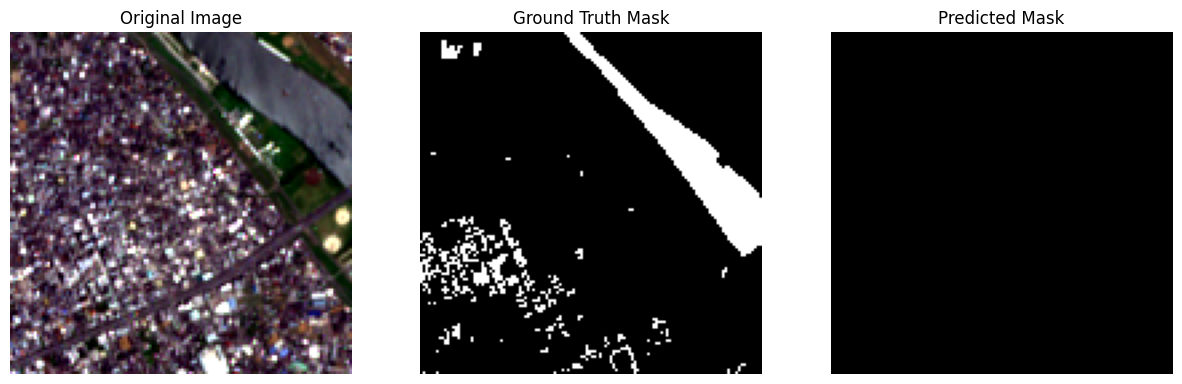

In [30]:
def visualize_predictions(test_loader, model, num_images=5):
    model.eval()
    with torch.no_grad():
        for idx, (images, masks) in enumerate(test_loader):
            images, masks = images.to(device), masks.to(device)
            
            # Get model outputs
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy()
            preds = (preds > 0.5).astype(np.uint8)
            
            for i in range(min(num_images, images.size(0))):
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                
                # Original image
                axs[0].imshow(images[i].cpu().permute(1, 2, 0))
                axs[0].set_title("Original Image")
                axs[0].axis("off")
                
                # Ground truth mask
                axs[1].imshow(masks[i].cpu().squeeze(), cmap="gray")  # Squeeze to remove the channel dimension
                axs[1].set_title("Ground Truth Mask")
                axs[1].axis("off")
                
                # Predicted mask
                axs[2].imshow(preds[i], cmap="gray")  # Directly use preds[i] since it's already squeezed
                axs[2].set_title("Predicted Mask")
                axs[2].axis("off")
                
                plt.show()
            
            # Stop after visualizing num_images
            if idx * test_loader.batch_size + i + 1 >= num_images:
                break

# Visualize the first 5 predictions in the test set
visualize_predictions(test_loader, model, num_images=5)


#### Train second Model (Tune Hyperparameters)

#### Second Model. <br> Visualize GT vs. Test Predictions without Hyper-Parameter Tuning

### 1.4 Data Augmentation